In [1]:
!pip install opensmile --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 10.4 MB/s eta 0:00:00


In [28]:
import os
import glob
import time
import pickle
import zipfile
import librosa
import opensmile
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix

### Dataset Loading

#### Google Colab or Local Notebook

For those who prefer working on their local machine or Google Colab, the cell below downloads the dataset from Google Drive, extracts it to your current working directory, and defines the `dataset_dir` variable pointing to the extracted folder. This provides a simple, reproducible way to load the dataset without needing to work directly from a Kaggle notebook.
<br>

**Note:** The dataset is aboout 16 MB.


In [2]:
# install gdown if not already installed
!pip install -q gdown

# download the fsdd.zip file from Google Drive using its file ID
!gdown 1pt75Fs4APfvxQ1FiuubEWkRJp7tjwndW

# unzip the downloaded file (assumes the zip file is named "fsdd.zip")
zip_filename = "fsdd.zip"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('./')

# remove the zip file after extraction
os.remove(zip_filename)

# define the dataset directory variable (assumes the extracted folder is named "fsdd")
dataset_dir = os.path.join(os.getcwd(), "fsdd")
print("Dataset directory:", dataset_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1pt75Fs4APfvxQ1FiuubEWkRJp7tjwndW
From (redirected): https://drive.google.com/uc?id=1pt75Fs4APfvxQ1FiuubEWkRJp7tjwndW&confirm=t&uuid=af1f0e93-e1ff-4626-8918-c04c12f73435
To: /content/fsdd.zip
100% 17.4M/17.4M [00:00<00:00, 102MB/s] 
Dataset directory: /content/fsdd


#### Kaggle

On a Kaggle Notebook, the dataset can be downloaded directly using the Kaggle API through the `kagglehub` package. The cell below downloads the latest version of the dataset from Kaggle and sets the `dataset_dir` variable to the path where the dataset files are located. This provides a quick and efficient method to access the dataset without needing additional steps.


In [ ]:
import kagglehub

# download latest version of the dataset
dataset_dir = kagglehub.dataset_download("toribiodiego/free-spoken-digit-dataset")

print("Path to dataset files:", dataset_dir)

## **1. Introduction and Objectives**

### **1.1 Context**
Welcome to the audio classification assignment!
<br>

In this *pre-game assignment*, we’ll work with the [Free-Spoken-Digit Dataset (FSDD)](https://github.com/Jakobovski/free-spoken-digit-dataset)—a collection of short audio recordings of speakers saying a single digit (0–9). Although this dataset is much simpler than real clinical data (like the Alzheimer’s speech recordings we'll be working on), it will provide an introduction to the end-to-end process of building a machine learning model, from working with raw audio to making predictions.
<br>
<br>

### **1.2 Key Terms**

Each section in this notebook will include a "Key Terms" subsection where we define important concepts from Signal Processing or Machine Learning. The goal is to keep these definitions lean enough to give you a good starting point into exploring the ML space, yet not so exhaustive that they distract from the hands-on experience. If you come across any term or concept that you’re unsure about or for which you do not have a satisfactory explanation, please feel free to reach out for clarification.

For practical illustration, we reference the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset—an essential benchmark in machine learning. MNIST consists of 70,000 images of handwritten digits (0–9), with each image being 28x28 pixels. The task is to classify each image into one of 10 classes. This dataset is used to anchor definitions with concrete examples when needed.

#### Definitions

**Model:**  
A model is a mathematical or computational system that learns patterns from data and makes predictions or decisions based on those patterns. In machine learning, a model is trained to capture relationships between inputs (data) and outputs (labels).  
- *Example:* A model learns which pixel patterns correspond to each handwritten digit, enabling it to predict the digit in a new image.

**Dataset:**  
A dataset is a collection of data used for training, validating, and testing machine learning models. It typically consists of pairs of input data (such as images, audio, or text) and their corresponding outputs (labels) that the model learns to predict.  
- *Example:* The input data are images of handwritten digits, and each image is paired with a label indicating the digit it represents.

**Labels:**  
Labels are the specific outputs assigned to individual examples in a dataset. They represent the correct answers or categories for the input data.

**Classes:**  
Classes refer to the complete set of possible categories into which the examples can be grouped.  
- *Example:* Each image is given a label (like "5"), and there are 10 possible classes (the digits 0 through 9) covering all the labels.

**Supervised Learning:**  
Supervised learning involves training a model on a dataset that includes both the inputs and their corresponding labels. The objective is for the model to learn the mapping from inputs to outputs so that it can predict the correct labels for unseen data.  
- *Example:* Each image is paired with its label (the correct digit), making it a supervised learning task.

**Unsupervised Learning:**  
Unsupervised learning is used when the dataset includes only inputs, with no labels provided. The goal is for the model to automatically discover the underlying structure or groupings in the data.  
- *Example:* Given a collection of unlabeled handwritten digit images, an unsupervised algorithm (like K-means clustering) might group similar images together, potentially revealing clusters corresponding to different digits.
<br>
<br>

### **1.3 Objective**

When you first receive a new dataset, it's essential to understand its structure, contents, and any patterns that could impact model performance. In this exercise, you'll inspect the Free-Spoken-Digit Dataset (**FSDD**), learn how the data is stored, understand the labeling system, and visually examine the dataset distribution. This will help you build good habits for data exploration, ensuring you can confidently begin modeling.

You'll primarily use Python's built-in libraries (**`os`**), as well as **`pandas`** and **`matplotlib`** for easy visualization.

> **Exercise 1**  
> Explore and understand the dataset structure before modeling:
>
> 1. **Inspect the File Structure**  
>       - **List Files:**  
>           - Use the **`os`** module to list and print the names of the first 10 `.wav` files from the dataset directory.  
>           - Confirm the file format clearly (e.g., `.wav`).  
>       - **Count Files:**  
>           - Determine and print the total number of `.wav` files to get an initial sense of dataset size.
> <br>

> 2. **Analyze the Naming Scheme**  
>       - **Examine Naming Format:**  
>           - Note that each file follows this naming convention:  
>             ```digit_speaker_recording-idx.wav```  
>               - **Digit (class):** Represents the digit spoken (0–9).  
>               - **Speaker:** Indicates the speaker’s identity.  
>               - **Recording Index:** Reflects the sequence number of recordings for each speaker-digit pair.  
>       - **Interpretation:**  
>           - Clearly explain how this naming scheme can help quickly identify important metadata (digit, speaker, recording number) from each audio file.  
>           - Briefly discuss the expected distribution of recordings per digit and per speaker based on this naming pattern.
> <br>

> 3. **Examine and Visualize Dataset Distribution**  
>       - **Parse File Names:**  
>           - Loop through all filenames and parse them into three separate components (digit, speaker, recording index).  
>           - Organize these parsed results into a clear and structured `pandas` DataFrame.  
>       - **Distribution Analysis:**  
>           - Use the DataFrame to count and summarize the number of recordings available for each digit.  
>           - Further group the data to count how many recordings each speaker provided for each digit.  
>       - **Visualization:**  
>           - Use **`matplotlib`** to plot a clearly labeled stacked bar chart showing the number of recordings per digit, with segments representing each speaker's contribution.  
>           - Label your axes clearly (e.g., "Digit," "Number of Recordings") and include a legend indicating speakers.
> <br>

> 3. **Reflect on Your Observations**  
>       - After visualizing the data, briefly comment on the balance of the dataset.  
>           - Are some digits better represented than others?  
>           - Do certain speakers contribute disproportionately more recordings?
>           - How might this impact your model’s ability to generalize?

**Additional Recommendations:**  
- Clearly document each step of your code, especially the parsing and visualization portions.  
- Ensure your DataFrame clearly labels columns (e.g., `"digit"`, `"speaker"`, `"repetition"`) to make analysis straightforward.  
- Get comfortable using **`pandas`** early, as it’s invaluable for structured data analysis throughout the machine learning pipeline.

### 1.1 Inspect the File Structure

In [6]:
# list 10 files in the directory
files = [f for f in os.listdir(dataset_dir) if f.endswith(".wav")]
print("Subset of Files:")
for f in files[:10]:
    print(f)

print("")
print("Total number of files:", len(files))

# the file format is .wav

Subset of Files:
0_theo_17.wav
6_lucas_23.wav
6_jackson_5.wav
8_yweweler_11.wav
9_yweweler_40.wav
2_george_32.wav
0_lucas_40.wav
9_nicolas_38.wav
8_lucas_39.wav
0_yweweler_36.wav

Total number of files: 3000


### 1.2 Naming Scheme

Each file is formated as:
    
```digit_speaker_recording-idx.wav```


- **Digit (Class):**  
  The first element (e.g., `0-9`) indicates the digit class.

- **Speaker (Person):**  
  The second element identifies the person who recorded the file.

- **Recording Index:**  
  The third element (e.g., `0-50`) is the recording index for that specific speaker-digit pair. Given that there are 3000 speech samples from 6 speakers, each speaker contributes 500 recordings in total. Since there are 10 digit classes, each speaker provides 50 recordings per digit class.

### 1.3 Dataset Distribution

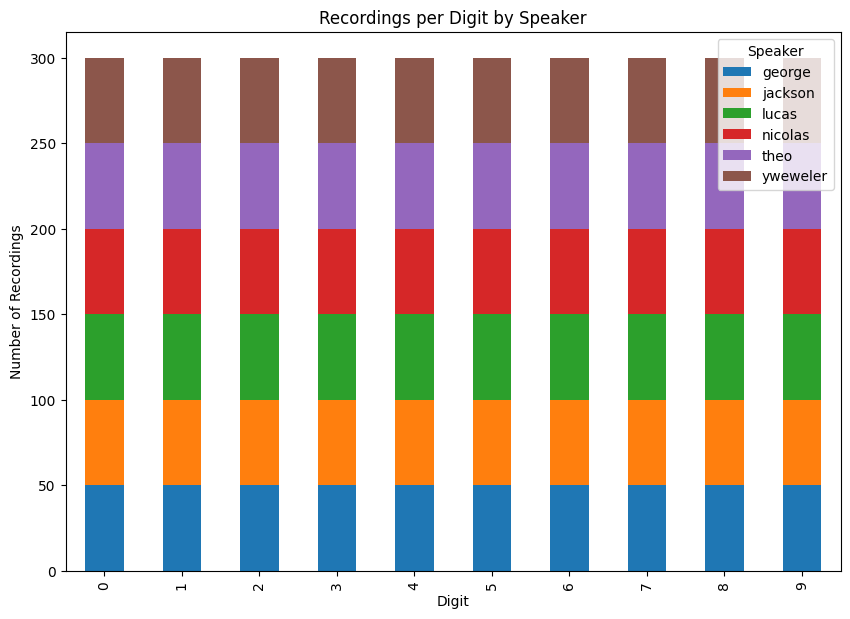

In [7]:
# parse the file names into components: digit, speaker, and repetition
parsed_files = []
for f in files:
    # expected filename format: digit_speaker_repetition.wav (e.g., "0_george_0.wav")
    parts = f.split("_")
    digit = parts[0]
    speaker = parts[1]
    # remove the .wav extension from the repetition part
    repetition = parts[2].replace(".wav", "")
    parsed_files.append({"filename": f, "digit": digit, "speaker": speaker, "repetition": repetition})

# create a DataFrame
df = pd.DataFrame(parsed_files)

# count the total number of recordings per digit
digit_counts = df['digit'].value_counts().sort_index()

# for each digit, count how many recordings each speaker provided
grouped = df.groupby(['digit', 'speaker']).size().unstack(fill_value=0)

# plot a stacked bar chart for recordings per digit by speaker
grouped.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel("Digit")
plt.ylabel("Number of Recordings")
plt.title("Recordings per Digit by Speaker")
plt.legend(title="Speaker")
plt.show()

## **2. Data Preprocessing**

### **2.1 Working With Audio Data**

Before training a model, it is crucial to prepare your audio data so that it is consistent and ready for analysis. In this section, you will learn to load audio files, inspect their waveforms, and extract key properties such as the sample rate. We will use the **`librosa`** library for these tasks.
<br>

When you load an audio file, you obtain:
  - **waveform**: an array of amplitude values over time.
  - **sample rate**: the number of audio samples recorded per second.

Understanding these properties helps you verify that the recordings are consistent and of good quality for further processing.
<br>
<br>

### **2.2 Key Terms**

#### Definitions

**Data Processing:**  
These are the steps you take to clean and transform raw data into a format that a machine learning model can use effectively.  
- *Example:* For MNIST, data processing might involve converting the raw image files into arrays of pixel values that can be fed into a model.

**Normalization:**  
This means scaling data so that it fits within a specific range, like 0 to 1, which makes it easier to compare features directly.  
- *Example:* When working with MNIST, you might scale the pixel values (which originally range from 0 to 255) down to a 0–1 range to help the model learn better.

**Standardization:**  
This is about adjusting the data so it has a mean of zero and a standard deviation of one. This way, each feature has equal importance during the learning process.  

**Truncation:**  
Truncation involves cutting off parts of the data to ensure all samples have a consistent size or to remove unnecessary information.  
- *Example:* Although MNIST images are already the same size, in other datasets, you might truncate longer audio recordings to keep them at a standard length for processing.

**Padding:**  
Padding means adding extra values (often zeros) to data samples so that they all match a required size or shape.  
- *Example:* If you were dealing with text sequences or variable-sized images, you might add padding to the sequences or images so that every input to the model has the same dimensions.

**Preprocessing Pipeline:**  
This is a series of data processing steps that are applied in a set order to prepare your entire dataset for modeling.  
- *Example:* An MNIST preprocessing pipeline might include converting images to arrays and normalizing the pixel valuesm before they go into the model.
<br>
<br>

### **2.3 Objective**

In this section, you'll become familiar with working directly with audio data by loading and inspecting audio files, visualizing waveforms, and analyzing basic audio properties. The goal is to ensure you understand the structure and characteristics of your data before proceeding to modeling. We’ll use **`librosa`** for audio processing, **`matplotlib`** for visualization, and optionally **`tqdm`** to track your progress through the dataset.

> **Exercise 2**  
> Explore, inspect, and visualize the audio dataset:
>  
> 1. **Inspect an Audio File**  
>       - Use `librosa.load()` to load a single `.wav` audio file from the dataset directory.  
>       -  Check and print the shape of the loaded waveform array and the sampling rate (e.g., using `.shape` and by directly printing the sampling rate).  
>       -  Plot the waveform clearly labeling the axes (e.g., time in seconds and amplitude). You can use `librosa.display.waveshow()` to simplify plotting.
> <br>

> 2. **Analyze Audio Properties Across the Entire Dataset**  
>       -  Loop through all audio files in the dataset (consider using `tqdm` for a progress bar).  
>       - For each audio file, calculate and store:
>           - The duration (length of the waveform divided by its sampling rate).
>           - The sampling rate.  
>       - Create histograms to visualize the distribution of audio durations and sampling rates using `matplotlib`.  
>       -  Check and summarize the range (minimum and maximum) of these values.  
> <br>

> 3. **Standardizing Audio Data:**  
>       -  Compute the **global mean** and **global standard deviation** of amplitudes across the entire dataset. (You may use `numpy.concatenate` to merge all waveforms for this calculation.)  
>            -  Print these global statistics clearly.  
>            -  Standardize a single waveform (for demonstration purposes, choose the first file) using these global mean and standard deviation values.  
>            -  Plot a clear comparison between the original waveform and its globally standardized version, labeling the axes and providing a legend to distinguish them.

**Additional Tips and Recommendations:**

- Consider using the `tqdm` library to display a progress bar when looping through the audio files. This is particularly useful for larger datasets.
- Clearly label and format your plots for readability, as these will help you better understand the data and communicate your findings effectively.
- Document your code clearly and concisely—remember, your notebook should serve as a clear reference for both yourself and others.  

### 2.1 Inspect Audio

Waveform Shape: (2384,)
Sampling Rate: 8000
Duration (seconds): 0.298



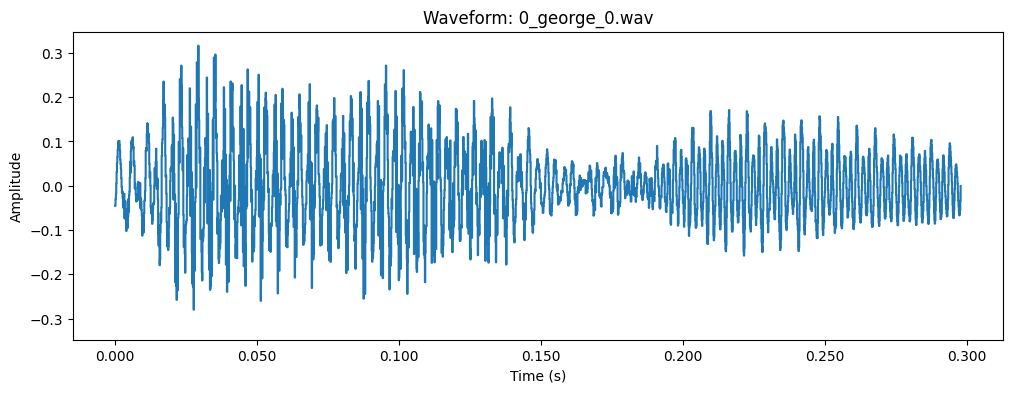

In [8]:
# Lload the .wav of a single audio file
sample_file = "/content/fsdd/0_george_0.wav"
waveform, sr = librosa.load(sample_file, sr=None)

# print the shape of the waveform array and sampling rate
print("Waveform Shape:", waveform.shape)
print("Sampling Rate:", sr)

# calculate and print the duration in seconds
duration = len(waveform) / sr
print("Duration (seconds):", duration)
print("")

# extract the file name from the path for the plot title
file_name = os.path.basename(sample_file)

# plot the waveform with the file name in the title
plt.figure(figsize=(12, 4))
librosa.display.waveshow(waveform, sr=sr)
plt.title(f"Waveform: {file_name}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### 2.2 Audio Properties

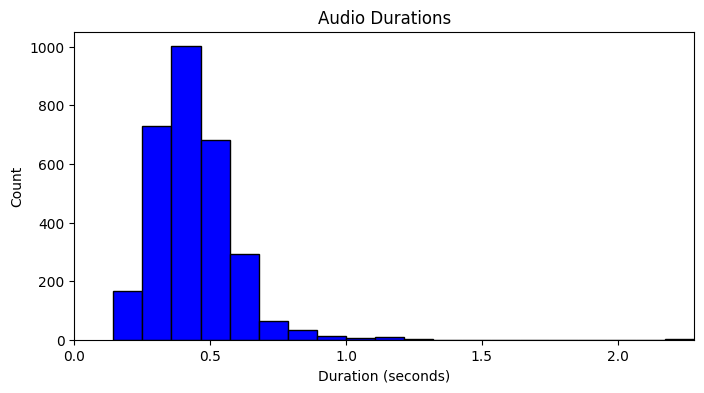

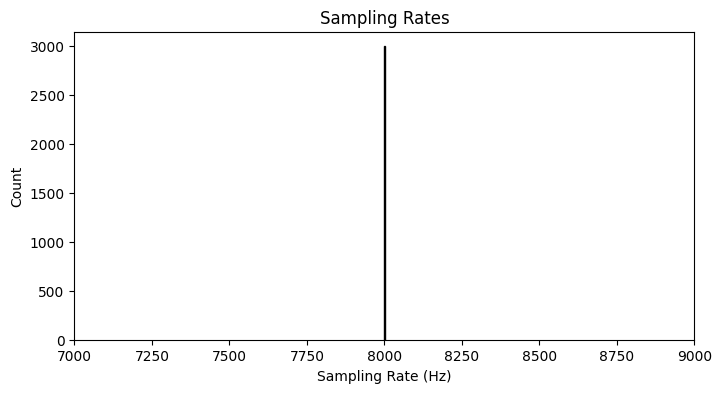


Duration range: 0.14 - 2.28 seconds
Sampling rate range: 8000 to 8000 Hz


In [11]:
audio_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".wav")]

all_waveforms = []
sample_rates = []
durations = []

# Loop through each file to extract waveform, sampling rate, and duration
for file in audio_files:
    y, sr = librosa.load(file, sr=None)
    all_waveforms.append(y)
    sample_rates.append(sr)
    durations.append(len(y) / sr)

# Plot histograms for durations and sampling rates (as before)
plt.figure(figsize=(8, 4))
plt.hist(durations, bins=20, edgecolor='black', color='blue')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Audio Durations")
plt.xlim(0, max(durations))
plt.show()

sr_value = sample_rates[0]
plt.figure(figsize=(8, 4))
plt.hist(sample_rates, bins=[sr_value - 0.5, sr_value + 0.5], edgecolor='black', color='salmon')
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Count")
plt.title("Sampling Rates")
plt.xlim(sr_value - 1000, sr_value + 1000)
plt.show()

print("")
print("Duration range: {:.2f} - {:.2f} seconds".format(min(durations), max(durations)))
print("Sampling rate range:", min(sample_rates), "to", max(sample_rates), "Hz")

### 2.3 Standardization

Global Mean: -0.0009670954
Global Standard Deviation: 0.06082984


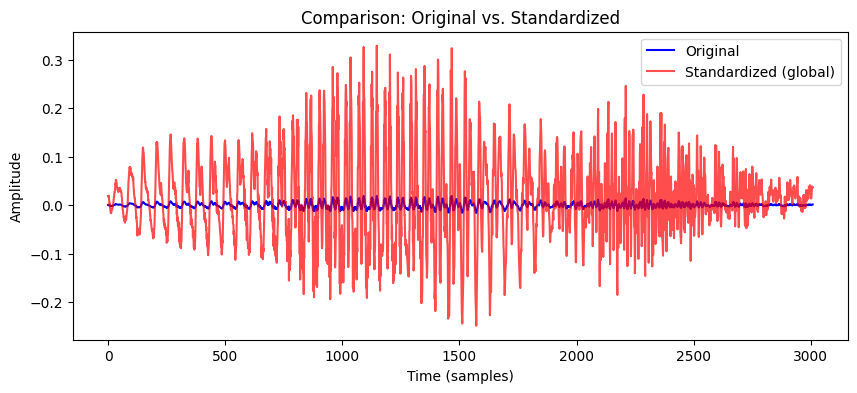

In [10]:
all_waveforms_concat = np.concatenate(all_waveforms)
global_mean = np.mean(all_waveforms_concat)
global_std = np.std(all_waveforms_concat)
print("Global Mean:", global_mean)
print("Global Standard Deviation:", global_std)

# For demonstration, standardize the first audio file using the global statistics
y, sr = librosa.load(audio_files[0], sr=None)
waveform_standardized = (y - global_mean) / global_std

plt.figure(figsize=(10, 4))
plt.plot(y, color='blue', label='Original')
plt.plot(waveform_standardized, color='red', label='Standardized (global)', alpha=0.7)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Comparison: Original vs. Standardized")
plt.legend()
plt.show()

## **3. Feature Extraction**

### **3.1 Why Extract Features?**

When working with audio data, raw waveforms can be challenging for many machine learning algorithms. Instead of feeding the entire audio signal into a model, we convert each audio file into a set of numerical features that capture important characteristics of the sound—such as pitch, loudness, and frequency content. These features simplify the learning process and can significantly boost model performance.
<br>
<br>

### **3.2 Key Terms**

#### Definitions

- **Spectrogram:**  
  A visual representation of the spectrum of frequencies of an audio signal as it varies with time. Spectrograms provide intuitive visual insights into audio signals by clearly illustrating how frequency content changes dynamically.
  - *Example:* In speech recognition, spectrograms show distinct patterns corresponding to different spoken digits or phonemes.

**Windowing:**  
  A technique used in audio processing where signals are divided into short segments (windows) for localized analysis. Commonly used when computing MFCCs or other spectral features.  
  - *Example:* Computing MFCCs typically involves splitting audio signals into overlapping frames to capture changes over time.

**Feature Extraction:**  
The process of converting raw audio data into numerical descriptors (features) that capture the important properties of the sound. These features are used as inputs to machine learning models.  
- *Example:* When analyzing a spoken word clip, you might extract features like pitch, tone, and rhythm so the model can learn to recognize different words.

**MFCCs (Mel-Frequency Cepstral Coefficients):**  
A popular set of features in speech and audio analysis that approximate how humans perceive sound by emphasizing critical frequency ranges.  
- *Example:* For a recording of someone saying "hello," MFCCs help capture the unique frequency patterns that distinguish that word from others.

**eGeMAPS:**  
A standardized set of features designed for analyzing emotional and paralinguistic aspects of speech. It includes various frequency, energy, and spectral parameters.  
- *Example:* In an emotion recognition task, eGeMAPS can help quantify subtle changes in a speaker's voice that might indicate happiness, sadness, or stress.

**Audio Feature Vector:**  
A numerical representation of an audio clip, created by combining various extracted features.  
- *Example:* If you extract 13 MFCC coefficients along with additional features like energy and pitch, you might end up with a vector of 20 or more values that summarizes the audio clip’s characteristics.

**Feature Extraction Pipeline:**  
The sequence of steps you follow to compute and save features from raw audio data. Once extracted, these features are often saved (for example, as CSV files or NumPy arrays) so that you can quickly load them for future experiments without needing to reprocess the audio each time.  
- *Example:* In a project analyzing a collection of interview recordings, you might set up a pipeline that automatically processes each audio file, extracts MFCCs and eGeMAPS features, and then stores them for quick access during model training.
<br>
<br>

### **3.3 Objective**

In this section, you’ll extract meaningful audio features from raw audio data to make them suitable inputs for machine learning models. You'll learn how to compute widely used audio features such as MFCCs and eGeMAPS. Additionally, you'll practice saving and loading processed data, which is crucial for efficient workflows.

We’ll use **`librosa`** for MFCC extraction, **`openSMILE`** for extracting eGeMAPS features, and **`matplotlib`** for visualizations. You'll also learn to manage datasets efficiently by saving and reloading processed data.

> **Exercise 3**  
> Extract, visualize, and store audio features from your dataset:
>  
> **1. Extract and Visualize Spectrogram and MFCC Features**  
> - Load an audio file using `librosa.load()`.  
> - Compute and visualize a **spectrogram** of the audio signal.  
>   - Convert the spectrogram to the decibel (dB) scale for better visualization clarity.  
>   - Limit the displayed frequencies to **4000 Hz** to make important audio characteristics clearer.  
>   - Ensure your plot has labeled axes indicating frequency (Hz), time (seconds), and intensity (dB).
> - Extract **MFCC features** (use 13 coefficients) from the audio file.  
>   - Print the shape of the MFCC feature array clearly.  
>   - Visualize the MFCC features using `librosa.display.specshow()`.  
> <br>

> 2. **Extract eGeMAPS Features Using openSMILE**  
>       - Use the **openSMILE** toolkit to extract eGeMAPS features from a single audio file (this involves calling openSMILE via Python).  
>       - Clearly print the shape of the extracted feature array and briefly comment on what the shape implies about the number of features extracted.  
>       - (Hint: You may define a helper function in Python to simplify feature extraction from openSMILE’s output format.)  
> <br>

> 3. **Saving and Reloading Features**  
>       - After extracting the eGeMAPS features, save them to disk using a convenient file format such as CSV or NumPy binary (`.npy`) format. (You might use Python’s built-in file I/O or NumPy’s saving functionality.)  
>       - Reload the features from the saved file and print their shape to verify they match the original features exactly. This practice helps you avoid repeatedly extracting features, especially from large datasets.  
> <br>

> 4. **Prepare the Entire Dataset for Modeling**  
>       - Loop through all audio files in your dataset (consider using **`tqdm`** to display a progress bar).  
>           - For each file:
>               - Extract the raw eGeMAPS features.
>               - Store the associated digit label.
>       - Compute global statistics (mean and standard deviation) across all extracted eGeMAPS features. (You may find `numpy.concatenate()` helpful here.)  
>       - Using these global statistics, create three different versions of your dataset features for further experimentation:
>           - **Raw:** Original extracted features with no modifications.
>           - **Standardized:** Features standardized using the global mean and standard deviation.
>           - **Standardized + Noise:** Features that have been standardized and then had small Gaussian noise added (useful for testing robustness).  
> <br>

> 5. **Saving Processed Feature Sets**  
>       - Save each of the three feature sets separately, clearly labeling them (e.g., `egemaps_raw.npy`, `egemaps_std.npy`, `egemaps_std_noise.npy`).  
>       - Also save the labels array separately for easy reference in future modeling tasks.
>       - After saving, load each feature set again to verify the saved data matches the original feature arrays. Print out their shapes to confirm successful saving and loading.

**Additional Guidance:**  
- Clearly document your functions, particularly when integrating external tools like openSMILE.  
- Verify your results step-by-step to catch any issues early on.  
- If you encounter difficulties with openSMILE, ensure it is installed and configured correctly—feel free to ask if you're uncertain about setup.  


### 3.1 Extract MFCCs

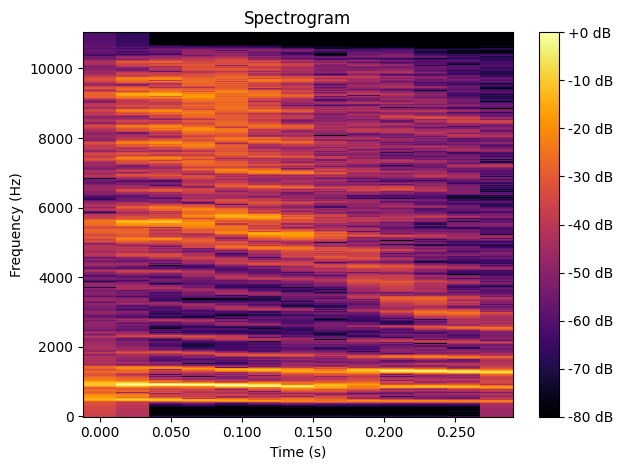

MFCC shape: (13, 13)


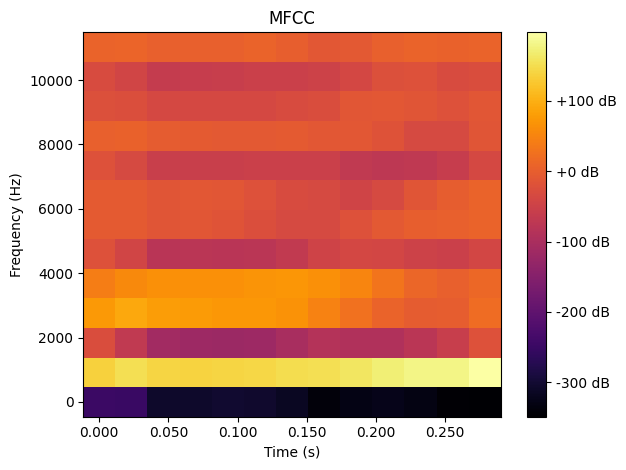

In [20]:
# load audio file (replace with your own file path if needed)
audio_file = "/content/fsdd/0_george_0.wav"
waveform, sr = librosa.load(audio_file)

# parameters for STFT
n_fft = 2048      # FFT window size
hop_length = 512  # Step between windows

# compute the spectrogram: square of the magnitude of the STFT
spectrogram = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)) ** 2

# convert the power spectrogram to decibels
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# compute the frequency bins for the spectrogram
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
# find the index corresponding to frequencies <= 4000 Hz
max_freq_idx = np.where(freqs <= 4000)[0][-1] + 1
# slice the spectrogram to include frequencies up to 4000 Hz
spectrogram_db_cut = spectrogram_db[:max_freq_idx, :]

# define a function for displaying the spectrogram
def show_plot(data, title, sr, hop_length, cmap="inferno", x_axis="time", y_axis="hz"):
    librosa.display.specshow(data, sr=sr, x_axis=x_axis, y_axis=y_axis,
                             hop_length=hop_length, cmap=cmap)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

# plot the spectrogram, showing only frequencies up to 4000 Hz
show_plot(spectrogram_db_cut, "Spectrogram", sr, hop_length, cmap="inferno")

# compute MFCC features
mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13)

# display shape of extracted MFCC features
print("MFCC shape:", mfccs.shape)
# Plot the MFCCs


# plot the MFCCs
show_plot(mfccs, "MFCC", sr, hop_length, cmap="inferno", y_axis="linear")

### 3.2 Extract eGeMAPS Features

In [21]:
# eGeMAPS extraction using openSMILE
def extract_eGeMAPS(audio_path):
    """
    Extract eGeMAPS features from an audio file using openSMILE.
    This function uses the eGeMAPSv02 feature set at the Functionals level.
    Returns a NumPy array of eGeMAPS features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    # process the audio file to extract features
    features = smile.process_file(audio_path)

    # convert the features (usually a pandas DataFrame) to a NumPy array
    return features.values.flatten()

# example usage for a single file
egemaps_features = extract_eGeMAPS(audio_file)
print("eGeMAPS feature shape:", egemaps_features.shape)

eGeMAPS feature shape: (88,)


### 3.3 Save and Reload Features

In [22]:
# save the extracted eGeMAPS features to a file
with open("egemaps_features.pkl", "wb") as f:
    pickle.dump(egemaps_features, f)

# reload the saved file
with open("egemaps_features.pkl", "rb") as f:
    reloaded_egemaps = pickle.load(f)

# verify that reloaded features match the original
print("Original shape:", egemaps_features.shape)
print("Reloaded shape:", reloaded_egemaps.shape)
print("Data match:", np.allclose(egemaps_features, reloaded_egemaps))

Original shape: (88,)
Reloaded shape: (88,)
Data match: True


### 3.4 Extract Feature for the Entire Dataset

In [23]:
def standardize(features, mean_val=None, std_val=None):
    """
    Standardizes a feature vector (zero-mean, unit-variance).
    If mean_val and std_val are provided, use those;
    otherwise compute from 'features'.
    """
    if mean_val is None:
        mean_val = np.mean(features, axis=0)
    if std_val is None:
        std_val = np.std(features, axis=0) + 1e-8  # avoid division by zero
    return (features - mean_val) / std_val, mean_val, std_val

def add_gaussian_noise(features, noise_level=0.01):
    """
    Adds Gaussian noise with mean=0 and std=noise_level to features.
    """
    noise = np.random.normal(0, noise_level, size=features.shape)
    return features + noise

audio_files = glob.glob(os.path.join(dataset_dir, "*.wav"))

# we'll store raw eGeMAPS features and their labels in lists
raw_egemaps_list = []
digit_labels = []

# 1) collect raw eGeMAPS for all files (for global mean/std) AND track labels
for fpath in tqdm(audio_files, desc="Extracting eGeMAPS features"):
    fname = os.path.basename(fpath)
    parts = fname.split("_")
    digit_str = parts[0]

    # convert the digit portion to an integer label
    digit_label = int(digit_str)

    # extract raw eGeMAPS features
    feats = extract_eGeMAPS(fpath)
    raw_egemaps_list.append(feats)
    digit_labels.append(digit_label)

# convert to NumPy arrays
raw_egemaps_array = np.array(raw_egemaps_list)
digit_labels = np.array(digit_labels)

# compute global mean and std from the raw features
global_mean = np.mean(raw_egemaps_array, axis=0)
global_std = np.std(raw_egemaps_array, axis=0) + 1e-8

# 2) now create three versions of the features (raw, std, std+noise)
raw_egemaps_processed = []
std_egemaps_processed = []
noise_egemaps_processed = []

for feats in raw_egemaps_array:
    # a. raw (no post-processing)
    raw_egemaps_processed.append(feats)

    # b. standardized
    std_feats, _, _ = standardize(feats, mean_val=global_mean, std_val=global_std)
    std_egemaps_processed.append(std_feats)

    # c. standardized + noise
    noise_feats = add_gaussian_noise(std_feats, noise_level=0.01)
    noise_egemaps_processed.append(noise_feats)

raw_egemaps_processed = np.array(raw_egemaps_processed)
std_egemaps_processed = np.array(std_egemaps_processed)
noise_egemaps_processed = np.array(noise_egemaps_processed)

# 3) save each set of features plus the labels for future use
np.save("egemaps_raw.npy", raw_egemaps_processed)
np.save("egemaps_std.npy", std_egemaps_processed)
np.save("egemaps_std_noise.npy", noise_egemaps_processed)
np.save("labels.npy", digit_labels)

print("Raw eGeMAPS shape:", raw_egemaps_processed.shape)
print("Standardized eGeMAPS shape:", std_egemaps_processed.shape)
print("Standardized + Noise eGeMAPS shape:", noise_egemaps_processed.shape)
print("Labels shape:", digit_labels.shape)
print("Feature extraction complete.")

Extracting eGeMAPS features: 100%|██████████| 3000/3000 [02:53<00:00, 17.28it/s]

Raw eGeMAPS shape: (3000, 88)
Standardized eGeMAPS shape: (3000, 88)
Standardized + Noise eGeMAPS shape: (3000, 88)
Labels shape: (3000,)
Feature extraction complete.


## **4. Building and Training Classifiers**


## **4. Building and Training Classifiers**

### **4.1 What is a Classifier?**

A **classifier** is a supervised machine learning algorithm that maps input features—such as MFCCs, spectral features, or other audio-derived numerical descriptors—to discrete output classes (e.g., the spoken digit "3"). Mathematically, it approximates a function:

$$
f(\mathbf{x}) = y,
$$

where $\mathbf{x}$ represents a feature vector extracted from the input data and $y$ is the predicted class label.

Classifiers learn by minimizing a **loss function**, which measures the difference between the predicted labels and the true labels in the training data. Recall the **Mean Squared Error (MSE)** from your Stochastic Processes class, defined as:

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2,
$$

where $y_i$ is the actual value and $\hat{y}_i$ is the predicted value. Although MSE is commonly used in regression problems, classification tasks often use loss functions like **cross-entropy** or **log loss** to guide the training process toward accurate predictions.
<br>
<br>

### **4.2 Key Terms**

#### Definitions

**Classifier:**  
A model that assigns input data to predefined categories or classes.  
- *Example:* An email filter that classifies incoming emails as either "spam" or "not spam."

**Supervised Learning:**  
A type of machine learning where the model learns from labeled data (data paired with known outcomes). The goal is for the model to learn the mapping from inputs to outputs to correctly predict new, unseen data.  
- *Example:* Predicting handwritten digit labels given images labeled with the correct digits.

**Training:**  
The process of providing labeled examples to a classifier so it can learn the relationships between input features and output labels.  
- *Example:* Training a speech recognition model with audio features labeled by spoken words.

**Testing:**  
Evaluating the performance of a trained model on a set of examples that it has not seen before.  
- *Example:* After training a digit classifier, testing involves evaluating its accuracy on a new set of digit recordings.

**Generalization:**  
The ability of a classifier to perform accurately on new, unseen data rather than only the data it was trained on. Good generalization means the model captures underlying patterns instead of memorizing specific training examples.  
- *Example:* A well-generalizing spam classifier correctly identifies spam emails it has never encountered before, not just those in the training dataset.

**Decision Boundary:**  
  A visual boundary in feature space that separates predicted classes, illustrating how a classifier partitions data.  
  - *Example:* A decision boundary of logistic regression is a straight line (in 2D space), clearly separating two classes.

**Loss Function:**  
A mathematical function measuring how far the model’s predictions are from the true labels. Minimizing the loss guides the training process.  
- *Example:* **Cross-Entropy Loss**, commonly used in classification, measures how well the predicted probabilities match the actual class labels.

**Cross-Entropy Loss (Log Loss):**
  A loss function commonly used in classification tasks, measuring how well predicted probabilities align with actual class labels.  
  $$
  \text{Cross-Entropy} = -\frac{1}{n}\sum_{i=1}^{n}[y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)]
  $$
  - *Example:* When training a digit classifier, cross-entropy loss penalizes incorrect probability assignments, guiding the model toward more confident, accurate predictions.

**Gradient:**  
A vector of partial derivatives indicating the direction and magnitude in which model parameters must be adjusted to minimize the loss function.  
- *Example:* In neural network training, gradients inform how weights should be updated to reduce prediction error iteratively.

**Gradient Descent:**  
An optimization algorithm that iteratively adjusts model parameters in the direction that reduces the loss function most rapidly (direction of steepest descent).  
- *Example:* Adjusting neural network weights repeatedly to minimize classification errors.

**Local Minimum:**  
A point in parameter space where the loss function has a lower value compared to its immediate surroundings, but not necessarily the lowest possible value overall.  
- *Example:* A neural network training process might stop improving prematurely by settling into a local minimum.

**Global Minimum:**  
The point in parameter space that yields the absolute lowest loss value, representing optimal model performance.  
- *Example:* The ideal scenario where a model achieves the lowest possible prediction error across all possible parameter values.

**Overfitting:**  
When a model performs exceptionally well on training data but poorly on unseen data, indicating that it has learned noise or overly specific details rather than generalizable patterns.  
- *Example:* A decision tree that perfectly memorizes the training set but misclassifies new examples is overfitting.

**Underfitting:**  
When a model fails to adequately capture the underlying patterns in the data, resulting in poor performance on both training and test data.  
- *Example:* A linear classifier unable to correctly separate complex, non-linear classes clearly, resulting in low accuracy.

**Regularization:**  
Techniques used to reduce overfitting by adding constraints or penalties that encourage simpler models.  
- *Example:* L2 regularization penalizes large coefficients in logistic regression, leading to more robust and generalized predictions.

**Bias-Variance Trade-off:**
  The trade-off between a model being too simple (high bias, underfitting) and too complex (high variance, overfitting).  
  - *Example:* A shallow decision tree may underfit (high bias), while a very deep decision tree may overfit (high variance).


**Accuracy:**  
The proportion of correct predictions made by the classifier. Defined mathematically as:  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  
- *Example:* If a classifier correctly identifies 95 out of 100 audio samples, it achieves 95% accuracy.

**Confusion Matrix:**  
A table summarizing a classifier’s performance, showing correct and incorrect predictions explicitly across classes.

|                       | **Predicted Positive** | **Predicted Negative** |
|-----------------------|------------------------|------------------------|
| **Actual Positive**   | TP (True Positive)     | FN (False Negative)    |
| **Actual Negative**   | FP (False Positive)    | TN (True Negative)     |

**Precision and Recall:**  
- **Precision** measures the accuracy of the positive predictions:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
- **Recall** measures the ability to correctly detect positive instances:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**F1 Score:**  
The harmonic mean of precision and recall, providing a balance between the two metrics:  
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$  
- *Example:* Used in medical diagnostics to balance correctly detecting disease (high recall) against false alarms (precision).

**Confusion Matrix Analysis:**  
Examining the confusion matrix in detail to understand the nature and distribution of classification errors. Helpful in diagnosing which classes the model confuses frequently.

**Decision Boundary Visualization:**  
Graphical visualization of boundaries separating predicted classes. Useful for intuitively understanding how a classifier makes decisions based on features.

**Regularization:**  
A method to prevent overfitting by adding penalties to complex models. Examples include L1 and L2 regularization.  
- *Example:* Penalizing large model parameters (weights) to encourage simpler models.

**Hyperparameters:**  
Values chosen by the practitioner before training, which govern the learning process, such as the learning rate or number of trees. Unlike model parameters, hyperparameters are not learned from data.

**Expert Systems:**  
Models that use explicitly defined, handcrafted rules by human experts rather than learned rules from data.  
- *Example:* A medical diagnosis tool that uses a specific temperature threshold to define a fever.

**Learned Systems:**  
Models that learn rules and patterns directly from data rather than predefined rules.  
- *Example:* A neural network trained to classify images into different animal species.

**Function Approximator:**  
A model that learns to map input features to outputs by approximating the underlying relationship.  
- *Example:* A classifier that maps audio features to spoken digits.
<br>
<br>

### **On Classifiers**

Below are foundational classifiers, each with unique strengths, weaknesses, and suitable application scenarios:

**Logistic Regression:**  
A linear model estimating the probability of class membership using a logistic function, effective when class boundaries are approximately linear.  
- *Strengths:* Fast, interpretable, effective baseline.  
- *Weaknesses:* Limited when relationships are complex or nonlinear.  
- *Example:* Predicting student pass/fail based on study hours and attendance.

**Decision Tree:**  
Partitions data into subsets based on feature thresholds, forming a branching structure.  
- *Strengths:* Intuitive, easy to interpret and visualize, handles nonlinearity.  
- *Weaknesses:* Prone to overfitting, unstable with slight changes in data.  
- *Example:* Classifying loan approval by sequentially checking credit score and income levels.

**Random Forest:**  
An ensemble of many decision trees, each trained on random subsets of data and features, combining their predictions for improved accuracy and reduced overfitting.  
- *Strengths:* Robust to noise, reduces variance of single-tree models.  
- *Weaknesses:* Less interpretable, computationally heavier than a single decision tree.  
- *Example:* Accurately diagnosing diseases by aggregating multiple decision-tree predictions.

**XGBoost (Extreme Gradient Boosting):**
A powerful ensemble method building trees sequentially, each new tree correcting errors of previous trees. Utilizes gradient boosting, which minimizes the loss function using gradients.  
- *Strengths:* Excellent performance, handles nonlinear relationships effectively, popular in competitions due to predictive power.  
- *Weaknesses:* Computationally intensive, complex hyperparameter tuning required.  
- *Example:* Predicting house prices accurately by iteratively refining predictions based on previous errors.

**Multi-Layer Perceptron (MLP; Neural Networks):**  
Consists of interconnected layers of neurons (nodes), using nonlinear activation functions to model complex relationships. Training occurs via gradient descent and backpropagation (adjusting weights to minimize loss).  
- *Strengths:* Handles extremely complex, nonlinear problems.  
- *Weaknesses:* Prone to local minima, requires careful hyperparameter tuning, data-hungry.  
- *Example:* Recognizing handwritten digits from pixel patterns, speech recognition tasks, and complex classification problems.

**Ensemble Methods:**  
Combine predictions from multiple models to improve accuracy and robustness. Common methods include Random Forests, Gradient Boosting, and voting ensembles.  
- *Strengths:* Improved accuracy, reduced overfitting.  
- *Weaknesses:* Less interpretable, increased complexity.  
- *Example:* Combining several weather prediction models to achieve highly accurate forecasts.
<br>
<br>

**Libraries you'll frequently use:**  
- **`scikit-learn`** (for Logistic Regression, Decision Trees, Random Forests, MLP)  
- **`XGBoost`** (optimized gradient boosting implementation)  
- **`TensorFlow` or `PyTorch`** (for advanced neural networks beyond basic MLP).
<br>
<br>

##### **Additional Notes on Classifiers**
In this section, we've introduced several common classifiers, mainly through practical examples and general explanations. However, it's important to keep in mind that these models aren't just black-box tools you call from libraries like `sklearn`. Each classifier is built around specific mathematical principles, and each comes with its own strengths, weaknesses, and appropriate use cases. Understanding these differences—even at a high level—can greatly enhance your intuition and your ability to choose the right classifier for your data and task.

The descriptions provided above are intentionally simplified to give you an accessible starting point. If you're curious about the deeper theoretical aspects—such as how decision boundaries are formed, the math behind optimization algorithms like gradient descent, the specific loss functions that classifiers minimize, or how concepts like overfitting and regularization shape model performance—I'll be creating additional notes diving into these topics.

These supplementary notes aren't required reading, but they'll provide valuable insights if you want to gain a more thorough understanding of how these classifiers actually work under the hood.
<br>
<br>

### **4.3 Objective**

In this section, you'll build and train multiple classifiers using the features extracted from your audio dataset. This exercise will give you hands-on experience with training, evaluating, and comparing classifiers. Additionally, you'll visualize and summarize model performance clearly, becoming familiar with helpful Python libraries like **`scikit-learn`**, **`tabulate`**, and visualization tools like **`matplotlib`** and **`seaborn`**.

> **Exercise 4**  
> Train, evaluate, and compare classifiers to recognize spoken digits using different feature preprocessing approaches:
>
> 1. **Train Multiple Classifiers**  
>       - Load the three variants of saved eGeMAPS features (`raw`, `standardized`, and `standardized+noise`) as NumPy arrays (using `np.load()`).
>       - Load the corresponding labels.
>       - Split each feature set into training and test sets. Consider using `train_test_split` from `sklearn` with a fixed random seed (`random_state=42`) for reproducibility.
>       - Define and train five classifiers from **`sklearn`**:
>           - Logistic Regression (`LogisticRegression`)
>           - Decision Tree (`DecisionTreeClassifier`)
>           - Random Forest (`RandomForestClassifier`)
>           - XGBoost (`XGBClassifier`)
>           - Multi-Layer Perceptron (MLP) (`MLPClassifier`)
>       - Store your trained classifiers in an organized dictionary for later reference.
> <br>

> 2. **Evaluate and Visualize Classifier Accuracy**  
>       - For each trained model and preprocessing variant, compute predictions using the `.predict()` method on the test data.
>       - Calculate and record the accuracy for each classifier and preprocessing variant.
>       - Using `matplotlib`, create a clear grouped bar chart to visually compare the accuracy scores across the three preprocessing variants (Raw, Standardized, Standardized+Noise).  
>            - Clearly label your axes and provide a legend to distinguish preprocessing methods.
> <br>

> 3. **Summarize Model Performance Clearly (Using Tabulate)**  
>       - Use the `tabulate` package to create an organized table summarizing accuracy for each classifier (rows) across all three preprocessing variants (columns).  
>            - Provide descriptive headers and use the `"github"` format to enhance readability.
>       - Clearly indicate which combination of classifier and preprocessing variant achieved the highest accuracy.
> <br>

> 4. **Confusion Matrix Analysis (Detailed Evaluation)**  
>       - Based on your best preprocessing variant, select the corresponding test dataset.  
>       - Use your best-performing model to predict labels on this test set and calculate the confusion matrix using `confusion_matrix()` from `sklearn.metrics`.
>       - Visualize the confusion matrix using `seaborn` to plot a heatmap clearly labeling axes with class labels.  
>           - Ensure the heatmap displays clear annotations indicating correct and incorrect predictions.
> <br>

**Additional Guidance:**  
- Use clear variable naming conventions to keep track of your data, models, and preprocessing methods.
- Consider using the **`tqdm`** library to monitor the training progress of your models, particularly helpful when training complex models or larger datasets.
- Make sure to import and document clearly which libraries you’re using (`numpy`, `sklearn`, `xgboost`, `matplotlib`, `seaborn`, `tabulate`, etc.) in your notebook.  
- Document each step of your workflow clearly so that you (and your peers) can easily revisit your work later or replicate your results.

### 4.1 Train Multiple Classifiers

In [27]:
# 1) load previously saved features and labels
X_raw = np.load("egemaps_raw.npy")
X_std = np.load("egemaps_std.npy")
X_noise = np.load("egemaps_std_noise.npy")

# 2) load the correct labels
y = np.load("labels.npy")

# 3) split data into train/test sets for each preprocessing variant
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)
X_train_std, X_test_std, _, _ = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)
X_train_noise, X_test_noise, _, _ = train_test_split(
    X_noise, y, test_size=0.2, random_state=42
)

# 4) prepare the 5 models with revised hyperparameters to reduce warnings
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,  # increased for better convergence
        solver="lbfgs"  # ensure we use a solver that supports multinomial
    ),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss'
    ),
    "MLP": MLPClassifier(
        max_iter=200,
        early_stopping=True,    # stop early if no improvement
        n_iter_no_change=10     # how many epochs with no improvement before stopping
    )
}

# 5) we'll store the fitted models for each preprocessing step
trained_models = {
    "raw": {},
    "std": {},
    "noise": {}
}

# 6) train models on each feature set
for model_name, clf in models.items():
    # raw
    clf_raw = clf.fit(X_train_raw, y_train)
    trained_models["raw"][model_name] = clf_raw

    # standardized
    clf_std = clf.fit(X_train_std, y_train)
    trained_models["std"][model_name] = clf_std

    # standardized + Noise
    clf_noise = clf.fit(X_train_noise, y_train)
    trained_models["noise"][model_name] = clf_noise

print("Training complete for all models under all 3 preprocessing methods.")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training complete for all models under all 3 preprocessing methods.


### 4.2 Evalaute Model Performance

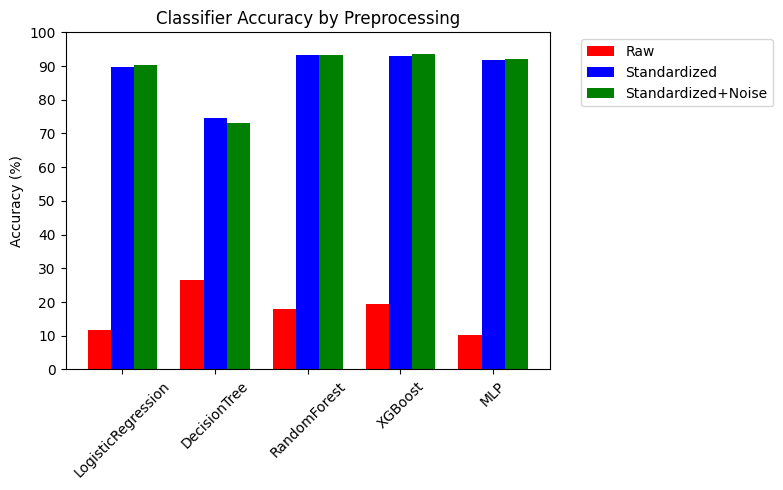

In [33]:
# 1) create a structure to store accuracy results
performance_results = {
    "raw": {},
    "std": {},
    "noise": {}
}

# 2) evaluate each trained model on its respective test set
for model_name in models.keys():
    # raw
    y_pred_raw = trained_models["raw"][model_name].predict(X_test_raw)
    acc_raw = accuracy_score(y_test, y_pred_raw)
    performance_results["raw"][model_name] = acc_raw

    # standardized
    y_pred_std = trained_models["std"][model_name].predict(X_test_std)
    acc_std = accuracy_score(y_test, y_pred_std)
    performance_results["std"][model_name] = acc_std

    # standardized + Noise
    y_pred_noise = trained_models["noise"][model_name].predict(X_test_noise)
    acc_noise = accuracy_score(y_test, y_pred_noise)
    performance_results["noise"][model_name] = acc_noise

# 3) prepare data for plotting
model_names = list(models.keys())  # e.g. ["LogisticRegression", "DecisionTree", ...]

# Build lists of accuracies (in percentages) for each model variant
acc_raw_pct = [performance_results["raw"][m] * 100 for m in model_names]
acc_std_pct = [performance_results["std"][m] * 100 for m in model_names]
acc_noise_pct = [performance_results["noise"][m] * 100 for m in model_names]

x_positions = np.arange(len(model_names))
bar_width = 0.25

color_raw = 'red'
color_std = 'blue'
color_noise = 'green'

plt.figure(figsize=(8, 5))
plt.bar(x_positions - bar_width, acc_raw_pct, width=bar_width, label="Raw", color=color_raw)
plt.bar(x_positions,             acc_std_pct, width=bar_width, label="Standardized", color=color_std)
plt.bar(x_positions + bar_width, acc_noise_pct, width=bar_width, label="Standardized+Noise", color=color_noise)
plt.xticks(x_positions, model_names, rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Classifier Accuracy by Preprocessing")
plt.yticks(np.arange(0, 101, 10))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 4.3 Summarize Performance

In [34]:
# print out a small table with the results
table_data = []
for model in model_names:
    row = [
        model,
        performance_results["raw"][model],
        performance_results["std"][model],
        performance_results["noise"][model]
    ]
    table_data.append(row)

headers = ["Model", "Raw eGeMAPS", "Std eGeMAPS", "Std+Noise eGeMAPS"]
print(tabulate(table_data, headers=headers, tablefmt="github"))

best_acc = 0
best_variant = None
best_model_name = None

for variant in performance_results:
    for model in performance_results[variant]:
        acc = performance_results[variant][model]
        if acc > best_acc:
            best_acc = acc
            best_variant = variant
            best_model_name = model

print("")
print(f"Best model: {best_model_name} with variant: {best_variant} achieving accuracy: {best_acc:.4f}")

| Model              |   Raw eGeMAPS |   Std eGeMAPS |   Std+Noise eGeMAPS |
|--------------------|---------------|---------------|---------------------|
| LogisticRegression |      0.118333 |      0.898333 |            0.903333 |
| DecisionTree       |      0.266667 |      0.745    |            0.73     |
| RandomForest       |      0.178333 |      0.931667 |            0.933333 |
| XGBoost            |      0.195    |      0.928333 |            0.936667 |
| MLP                |      0.101667 |      0.916667 |            0.92     |

Best model: XGBoost with variant: noise achieving accuracy: 0.9367


### 4.4 Confusion Matrix

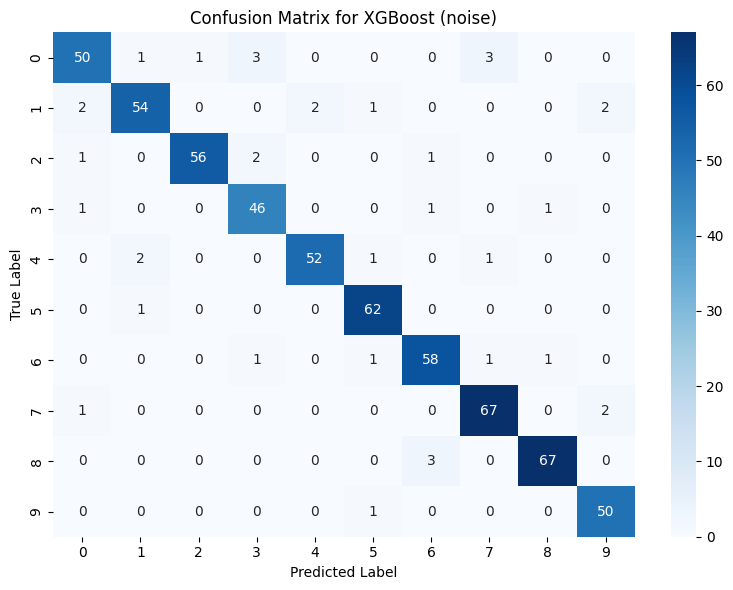

In [35]:
# select the corresponding test set based on the best variant
if best_variant == "raw":
    X_test_best = X_test_raw
elif best_variant == "std":
    X_test_best = X_test_std
elif best_variant == "noise":
    X_test_best = X_test_noise

# retrieve the best-performing model from the trained models dictionary
best_model = trained_models[best_variant][best_model_name]
y_pred_best = best_model.predict(X_test_best)

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {best_model_name} ({best_variant})")
plt.tight_layout()
plt.show()

## **5. Feature Importance and Selection**

### **5.1 Introducing Feature Importance and Selection**

Feature importance measures how much each individual feature contributes to a model’s predictions. By understanding which features are most influential, you can interpret your model better and simplify it by removing redundant or noisy features. This process—known as feature selection—can lead to models that generalize better, train faster, and are easier to explain.
<br>
<br>

### **5.2 Key Terms**
#### Definitions

**Feature Importance:**  
A metric that quantifies how significantly each feature (such as MFCC coefficients or spectral features) influences a model’s predictions.  
- *Example:* In a speech recognition model, feature importance might reveal that certain frequency bands are crucial for distinguishing vowels from consonants.

**Tree-Based Feature Importance:**  
An approach used by tree-based models (like Random Forests or XGBoost), which assigns importance scores based on how much each feature helps reduce uncertainty or impurity during training.  
- *Example:* In classifying weather conditions, a Random Forest might indicate temperature and humidity as the most important features, as these significantly reduce prediction uncertainty.

**Permutation Importance:**  
A model-agnostic approach to determining feature importance. It involves randomly shuffling feature values and measuring how much this impacts model accuracy—large drops imply high importance.  
- *Example:* In detecting fraud, shuffling the "transaction amount" feature values might substantially lower accuracy, indicating that this feature strongly influences model predictions.

**Feature Selection:**  
The process of identifying and retaining only the most relevant features from the full feature set to improve model performance, reduce training time, and simplify interpretation.  
- *Example:* For disease prediction, selecting only the most predictive medical indicators (e.g., specific biomarkers) from numerous tests.

**Filter Methods:**  
Simple and computationally efficient feature selection techniques that rank features based on statistical metrics (such as correlation or mutual information) independent of any classifier.  
- *Example:* Selecting the top 10 features with the highest correlation to the target class, irrespective of the model used.

**Wrapper Methods:**  
Iterative techniques that select features based on model performance. They repeatedly train models, removing the least important features at each iteration (e.g., Recursive Feature Elimination).  
- *Example:* Using Recursive Feature Elimination (RFE) to iteratively remove irrelevant words from a text classification task, identifying a minimal, highly predictive set of words.

**Embedded Methods:**  
Feature selection methods integrated directly into the model training process. These methods automatically determine the importance of features as the model learns, often using regularization techniques.  
- *Example:* Using Lasso regression (L1 regularization), which shrinks the coefficients of less relevant features toward zero, effectively selecting features during training.


**Top-K Feature Selection:**  
Selecting the K most important features based on predefined importance metrics or scores, simplifying the model and potentially improving efficiency.  
- *Example:* From 100 audio-derived features, you might select only the top 10 most influential to simplify the model and maintain good performance.

**Cross-Validation:**  
A validation technique where the dataset is divided into subsets (folds). The model is trained and evaluated multiple times using different folds, improving reliability of performance estimates.  
- *Example:* In 5-fold cross-validation, data is split into five subsets; the model is trained on four subsets and evaluated on the remaining one. This process repeats five times, ensuring robust validation.

**Multicollinearity:**  
  Occurs when two or more features are highly correlated with each other, potentially affecting feature importance interpretation and model stability.  
  - *Example:* If "age" and "experience" in job applicants are highly correlated, one might overshadow the importance of the other.

**Redundant Features:**  
  Features that provide no new information because their information is captured entirely by other features.  
  - *Example:* Including both temperature in Celsius and Fahrenheit as separate features provides no new predictive information.

**Irrelevant (Noisy) Features:**  
  Features that have little to no predictive power regarding the target outcome.  
  - *Example:* In predicting home prices, the color of the mailbox is likely irrelevant and should be removed.

**Curse of Dimensionality:**  
  Phenomenon where having too many features relative to the number of training examples can degrade model performance, often requiring feature selection or dimensionality reduction.  
  - *Example:* Classifying diseases based on thousands of genes with only dozens of patients may lead to poor performance without feature selection.


<br>
<br>

### **5.3 Objective**

In this exercise, you'll explore **feature importance and feature selection**, learning how to identify the most influential features for your model’s predictions. You’ll practice assessing the importance of each feature, simplifying your dataset based on this importance, and evaluating the impact of feature selection on classifier performance and efficiency. This is crucial for developing simpler, faster, and potentially more accurate machine learning models.

You'll primarily use the **Random Forest classifier** from **`scikit-learn`** because it provides intuitive and reliable feature importance scores.

> **Exercise 5**  
> Explore feature importance and apply feature selection techniques:
>  
> 1. **Assess Feature Importance Using Random Forest**  
>       - Train a Random Forest classifier (`RandomForestClassifier`) using your standardized feature set.  
>       - After training, extract and visualize feature importance scores clearly using `matplotlib`. Label your plot carefully, with axes titles (e.g., "Feature Index" and "Importance Score (%)").  
>       - To make interpretation easier, consider plotting importance scores as percentages.  
>       - Clearly label your plot axes and title your visualization to ensure clarity.
> <br>

> 2. **Identify and Summarize the Top Features**  
>       - Using the feature importance scores, identify and clearly list the top **10 most important features**.  
>       - Summarize these top features in a table using the **`tabulate`** package (recommended table format: `"github"` style).  
>            - Include columns such as "Rank," "Feature Index," "Feature Name," and "Importance Score (%)".
> <br>

> 3. **Evaluate Classifier Performance After Feature Selection**  
>       - Perform feature selection by removing the least important features incrementally. Consider removing 20%, 50%, 70%, and 90% of features based on their importance rankings.
>           - For each reduction level:
>               - Retrain the Random Forest classifier on the reduced feature set.
>               - Record and summarize:
>                   - The number of features kept.
>                   - The new accuracy score on the test set.
>                   - The training time required (use Python’s `time` module to track this).
>       - Summarize these results in a clearly formatted table using the **`tabulate`** package.  
> <br>

> 4. **Visualize the Impact of Feature Reduction**  
>       - Create a bar chart with `matplotlib` to visualize the impact of feature reduction on model accuracy.
>           - Clearly label the x-axis (percentage of features removed) and the y-axis (accuracy).
>           - Consider using distinct colors to enhance readability.
> <br>

> 5. **Reflect on Your Results**  
>       - Clearly summarize your observations:  
>           - Did reducing the number of features significantly affect model performance (accuracy)?
>           - Did training time decrease significantly with fewer features?
>           - Provide a brief discussion on why certain features might be more important and how removing less relevant features can influence the model’s performance and efficiency.

**Additional Recommendations:**  
- Use the **`tqdm`** library when retraining models on reduced feature sets to clearly track your progress, especially if you experiment with several reduction levels.
- Clearly comment your code, explaining each step—this will help you and your peers understand each phase of your analysis.  
- Document your findings briefly but clearly, explaining how the insights gained could inform future modeling decisions.


### 5.1 Assess Feature Importance Using Random Forest

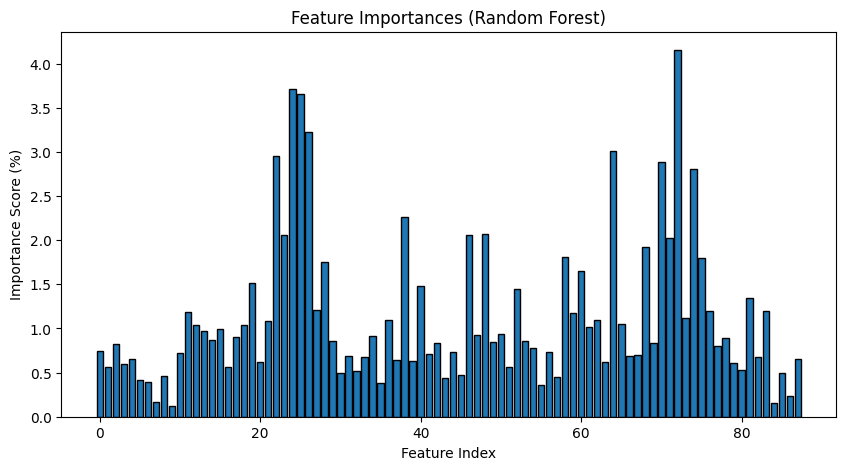


Top 10 Most Important Features:

|   Rank |   Index | Feature Name                | Importance Score (%)   |
|--------|---------|-----------------------------|------------------------|
|      1 |      72 | mfcc3V_sma3nz_amean         | 4.15%                  |
|      2 |      24 | mfcc2_sma3_amean            | 3.71%                  |
|      3 |      25 | mfcc2_sma3_stddevNorm       | 3.65%                  |
|      4 |      26 | mfcc3_sma3_amean            | 3.22%                  |
|      5 |      64 | slopeV500-1500_sma3nz_amean | 3.01%                  |
|      6 |      22 | mfcc1_sma3_amean            | 2.95%                  |
|      7 |      70 | mfcc2V_sma3nz_amean         | 2.88%                  |
|      8 |      74 | mfcc4V_sma3nz_amean         | 2.81%                  |
|      9 |      38 | logRelF0-H1-A3_sma3nz_amean | 2.27%                  |
|     10 |      48 | F2bandwidth_sma3nz_amean    | 2.07%                  |


In [36]:
# initialize openSMILE to get eGeMAPS feature names
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
feature_names = smile.feature_names

# train the full model using all features
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_std, y_train)

# retrieve feature importances from the model (normalized so that they sum to 1)
importances = rf_full.feature_importances_

# convert the importance scores to percentages for visualization
importances_percent = importances * 100

# visualize the feature importance scores (in percentages)
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances_percent)), importances_percent, edgecolor='black')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score (%)")
plt.show()

# get indices of the top 10 features (sorted in descending order of importance)
top_indices = np.argsort(importances)[-10:][::-1]

# prepare data for tabulation: Rank, index, feature name, and normalized importance percentage
table_data = []
for rank, idx in enumerate(top_indices, start=1):
    imp_percent = importances[idx] * 100  # Convert to percentage
    table_data.append([rank, idx, feature_names[idx], f"{imp_percent:.2f}%"])

# print the table using tabulate in GitHub-flavored markdown
headers = ["Rank", "Index", "Feature Name", "Importance Score (%)"]
print("\nTop 10 Most Important Features:\n")
print(tabulate(table_data, headers=headers, tablefmt="github"))

### 5.2 Feature Selection and Model Comparison

Baseline:

Full Feature Set -> #Features: 88, Accuracy: 0.940, Training Time: 3.120 seconds


Feature Reduction Comparison

|   Reduction (%) |   # Features |   Accuracy |   Training Time (s) |
|-----------------|--------------|------------|---------------------|
|              20 |           71 |      0.94  |               3.013 |
|              50 |           44 |      0.935 |               2.226 |
|              70 |           27 |      0.922 |               1.879 |
|              90 |            9 |      0.852 |               1.374 |


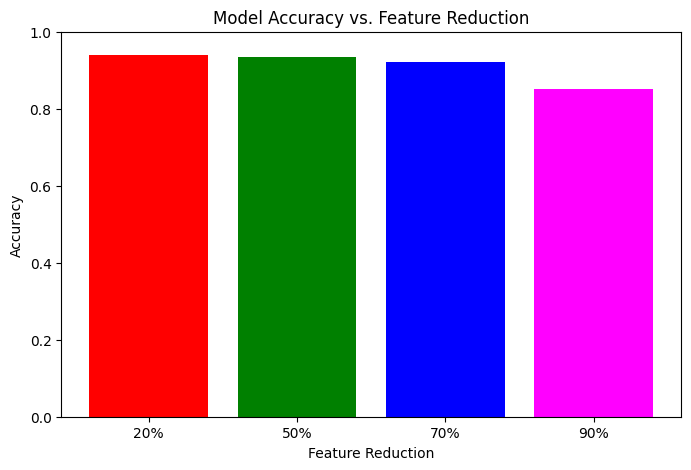

In [37]:
# train the full model for baseline measurements
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
start_time_full = time.time()
rf_full.fit(X_train_std, y_train)
end_time_full = time.time()
time_full = end_time_full - start_time_full
acc_full = rf_full.score(X_test_std, y_test)
num_features = X_train_std.shape[1]

print("Baseline:\n")
print(f"Full Feature Set -> #Features: {num_features}, Accuracy: {acc_full:.3f}, Training Time: {time_full:.3f} seconds\n")

# define the reduction levels (percentage of features to remove)
reductions = [20, 50, 70, 90]
colors = {20: 'red', 50: 'green', 70: 'blue', 90: 'magenta'}

results = []

# get the sorted feature indices (highest importance first)
sorted_indices = np.argsort(importances)[::-1]

for reduction in reductions:
    # calculate the number of features to keep (100 - reduction percentage)
    keep_percentage = 100 - reduction
    threshold_count = int(np.ceil((keep_percentage / 100.0) * num_features))

    # select the top features
    top_indices = sorted_indices[:threshold_count]
    X_train_reduced = X_train_std[:, top_indices]
    X_test_reduced = X_test_std[:, top_indices]

    # train the model on the reduced feature set
    rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
    start_time = time.time()
    rf_reduced.fit(X_train_reduced, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    accuracy = rf_reduced.score(X_test_reduced, y_test)

    # append the results
    results.append({
        "Reduction (%)": reduction,
        "# Features": threshold_count,
        "Accuracy": accuracy,
        "Training Time (s)": training_time
    })

# create a list of lists for tabulate
table_headers = ["Reduction (%)", "# Features", "Accuracy", "Training Time (s)"]
table_rows = [[res["Reduction (%)"], res["# Features"], f"{res['Accuracy']:.3f}", f"{res['Training Time (s)']:.3f}"] for res in results]
print("\nFeature Reduction Comparison\n")
print(tabulate(table_rows, headers=table_headers, tablefmt="github"))

# plot a histogram (bar plot) of the accuracies for each reduction level
reduction_labels = [f"{r}%" for r in reductions]
accuracies = [res["Accuracy"] for res in results]
bar_colors = [colors[r] for r in reductions]

plt.figure(figsize=(8, 5))
plt.bar(reduction_labels, accuracies, color=bar_colors)
plt.xlabel("Feature Reduction")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Feature Reduction")
plt.ylim(0, 1)
plt.show()

### 5.3 Reflect on Results

## **6. Hyperparameter Tuning**

### **6.1 Introduction to Hyperparameter Tuning**

When training a model, not all settings are learned from the data. Hyperparameters are values set before training begins that control how the model learns and its overall complexity. Choosing the right hyperparameters can have a dramatic effect on performance and generalization. In this section, you will learn how to systematically search for optimal hyperparameter values to improve your classifier’s accuracy.
<br>
<br>

### **6.2 Key Terms**

#### Definitions

**Model Parameters:**  
These are the values a model learns during training, such as the weights in a neural network.  
- *Example:* In a neural network, parameters are adjusted during training to minimize errors between predictions and actual values.

**Hyperparameters:**  
These are the values set before training that control the learning process and the model’s complexity, such as the number of trees in a Random Forest or the learning rate in a neural network.  
- *Example:* When training a neural network, you might set the learning rate and the number of hidden layers as hyperparameters.

**Grid Search:**  
An exhaustive search method that tests every combination of specified hyperparameter values to find the best configuration.  
- *Example:* In tuning a model, grid search might try every combination of learning rates and batch sizes to determine which setup gives the best validation performance.

**Random Search:**  
A method that tests random combinations of hyperparameters, which can be faster than grid search when the search space is large.  
- *Example:* Instead of testing every possible combination, random search might select a random set of hyperparameters, allowing you to quickly identify promising configurations.

**Cross-Validation:**  
A technique used to assess how well a model will generalize to an independent dataset by dividing the data into several folds and training/testing multiple times.  
- *Example:* In k-fold cross-validation, the dataset is split into k subsets, and the model is trained on k-1 folds while the remaining fold is used for testing. This process is repeated k times.

**Validation Accuracy:**  
This metric measures how well a model performs on unseen data during the tuning process, helping you gauge its ability to generalize.  
- *Example:* If a model achieves a validation accuracy of 85%, it means that, on average, it correctly predicts 85% of the outcomes on the validation sets during cross-validation.

**Overfitting:**  
  Hyperparameter tuning can inadvertently lead to overfitting if tuned aggressively on limited validation data.  
  - *Example:* Achieving very high validation accuracy during hyperparameter search but significantly worse performance on new unseen data.

**Early Stopping:**  
  A technique to halt training if performance on a validation set stops improving, thus preventing overfitting and reducing unnecessary training time.  
  - *Example:* Stopping neural network training when validation accuracy does not improve after 10 consecutive epochs.
<br>
<br>

### **6.3 Objective**

In this exercise, you'll explore the critical process of **hyperparameter tuning**, which involves systematically adjusting model settings to find the optimal balance between accuracy, complexity, and training time. You'll practice methods such as **Grid Search** to improve classifier performance, gaining experience with **`GridSearchCV`** from **`scikit-learn`**.

This exercise will demonstrate how choosing the right hyperparameters can significantly improve your model’s predictive power.

### **6.3 Objective**

In this exercise, you'll practice **hyperparameter tuning**, an essential step for maximizing your classifier's performance. You'll explore how systematically adjusting hyperparameters impacts model accuracy and generalization.

> **Exercise 6**  
> Perform hyperparameter tuning and evaluate its effect on model performance:
>
> 1. **Hyperparameter Tuning with Grid Search**  
>   - Choose one classifier (such as `RandomForestClassifier` or `MLPClassifier`) to perform hyperparameter tuning.
>   - Define a hyperparameter grid containing a few hyperparameters relevant to your chosen classifier.
>     - *Example (MLPClassifier):* number of hidden layers, learning rates, activation functions, or regularization strengths.
>   - Perform a **grid search** using `GridSearchCV` from `scikit-learn`:
>     - Set the cross-validation folds (`cv`) to at least 3 for reliable estimates.
>     - Consider using `n_jobs=-1` to leverage multiple CPU cores for efficiency.
>     - Clearly document the hyperparameters you're exploring.
>
> 2. **Evaluate and Compare Tuned vs. Untuned Models**  
>   - After your grid search finishes, clearly print the best hyperparameters found and their associated validation accuracy (`best_score_`).
>   - Using these best hyperparameters, evaluate your tuned classifier on the separate test set. Report this test accuracy clearly.
>   - Train a **default** (untuned) classifier with identical conditions, evaluate its performance on the same test set, and compare its accuracy with the tuned model.
>
> 3. **Reflect on Your Results**  
>   - Briefly discuss your findings:
>     - Did hyperparameter tuning improve accuracy? If so, by how much?
>     - What might these results suggest about the dataset or your chosen classifier?

**Additional Recommendations:**  
- Clearly comment your code for each step, particularly when defining hyperparameter grids, to document your thought process.  
- If interested, experiment with using **`RandomizedSearchCV`** (optional) to see how random sampling can speed up hyperparameter optimization for larger hyperparameter spaces.  
- As always, use descriptive variable naming to enhance code readability, aiding both your own understanding and that of your peers.


### 6.1 Hyperparameter Search




In [42]:
# exhaustive parameter grid for MLPClassifier
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'sgd'],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ['constant', 'adaptive']
}

# initialize a base MLPClassifier with a fixed random state and increased iterations
mlp_base = MLPClassifier(random_state=42, max_iter=500)

# we'll use raw features as the're the worst performing preprocessing method
grid_search = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=3,            # 3-fold cross-validation
    n_jobs=-1,       # Use all available CPU cores
    scoring='accuracy'
)

grid_search.fit(X_train_raw, y_train)
print("Grid Search complete.")

Grid Search complete.


### 6.2 Evaluate and Compare

In [43]:
# 1) best hyperparameters from the grid search
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (accuracy):", grid_search.best_score_)

# 2) evaluate the tuned model on the test set
best_mlp = grid_search.best_estimator_
tuned_test_acc = best_mlp.score(X_test_raw, y_test)

# 3) compare with a default MLP (no hyperparameter tuning)
mlp_default = MLPClassifier(random_state=42, max_iter=500)
mlp_default.fit(X_train_raw, y_train)
default_test_acc = mlp_default.score(X_test_raw, y_test)

print("\n=== Test Accuracy Comparison ===")
print(f"Default MLP: {default_test_acc:.4f}")
print(f"Tuned MLP:   {tuned_test_acc:.4f}")

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best CV Score (accuracy): 0.6750000000000002

=== Test Accuracy Comparison ===
Default MLP: 0.6967
Tuned MLP:   0.6750


### 6.3 Reflection